<a href="https://colab.research.google.com/github/madrigaljose/madrigaljose/blob/main/20210710_Madrigal_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
!pip install pandas-datareader
!pip install yfinance --upgrade --no-cache-dir
import pandas_datareader.data as pdr
import yfinance as yf

     |████████████████████████████████| 6.3MB 14.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.62-py2.py3-none-any.whl size=23867 sha256=35c88331df38ce6097d3a280a763a737a54e2e0a46b5f182ed89ce62bf98cf2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-n8yxrj44/wheels/38/5c/4a/7266ab5120deea4efa7a6dd8f6f41e913b77500ec3397c9f01
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
yf.pdr_override()
DE = pdr.get_data_yahoo('DE')#, start, end)
DE['DE_Close'] = DE[['Adj Close']]  
DE=DE[['DE_Close']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
Corn = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Corn.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Corn=Corn.set_axis(['Corn_Open','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Corn=Corn.dropna()
Cotton = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Cotton.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Cotton=Cotton.set_axis(['Cotton_Open','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Cotton=Cotton.dropna()
Wheat = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Wheat.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Wheat=Wheat.set_axis(['Wheat_Open','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Wheat=Wheat.dropna()
Soy = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Soy.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Soy=Soy.set_axis(['Soy_Open','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Soy=Soy.dropna()


In [ ]:
DE_df=DE
Corn_df=Corn[['Corn_Open']]
Cotton_df=Cotton[['Cotton_Open']]
Soy_df=Soy[['Soy_Open']]
Wheat_df=Wheat[["Wheat_Open"]]


In [ ]:
df1=Corn_df.join(Cotton_df, how='inner').join(Soy_df, how='inner').join(Wheat_df, how='inner').join(DE_df, how='inner')

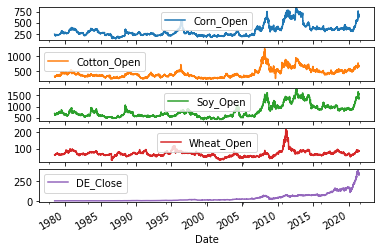

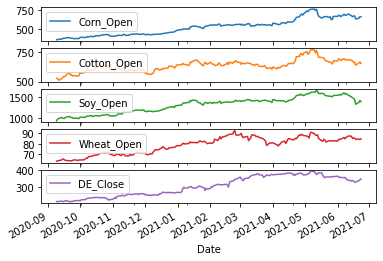

In [ ]:
plot_cols = ['Corn_Open','Cotton_Open','Soy_Open','Wheat_Open','DE_Close']
plot_features = df1[plot_cols]
#plot_features.index = Date
_ = plot_features.plot(subplots=True)

plot_features = df1[plot_cols][-200:-1]
#plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [ ]:
df1.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Corn_Open,10304.0,318.358780,126.456728,143.250000,231.47000,276.250000,365.250000,829.500000
Cotton_Open,10304.0,426.113505,147.702018,225.000000,325.34750,385.000000,495.250000,1248.000000
Soy_Open,10304.0,778.073018,273.707385,407.000000,574.00000,684.000000,915.000000,1778.500000
Wheat_Open,10304.0,69.017210,18.641078,28.200000,59.17750,66.575000,76.380000,215.620000
DE_Close,10304.0,37.480363,56.790942,1.453617,3.52429,12.992323,59.246207,393.205963


In [ ]:
column_indices = {name: i for i, name in enumerate(df1.columns)}

n = len(df1)
train_df = df1[0:int(n*0.7)]
val_df = df1[int(n*0.7):int(n*0.9)]
test_df = df1[int(n*0.9):]

num_features = df1.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

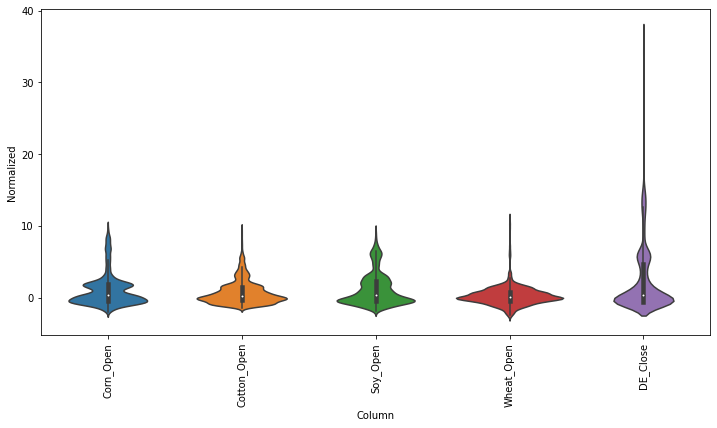

In [ ]:
df_std = (df1 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df1.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['DE_Close'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['DE_Close']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['DE_Close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['DE_Close']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='DE_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Days')

WindowGenerator.plot = plot

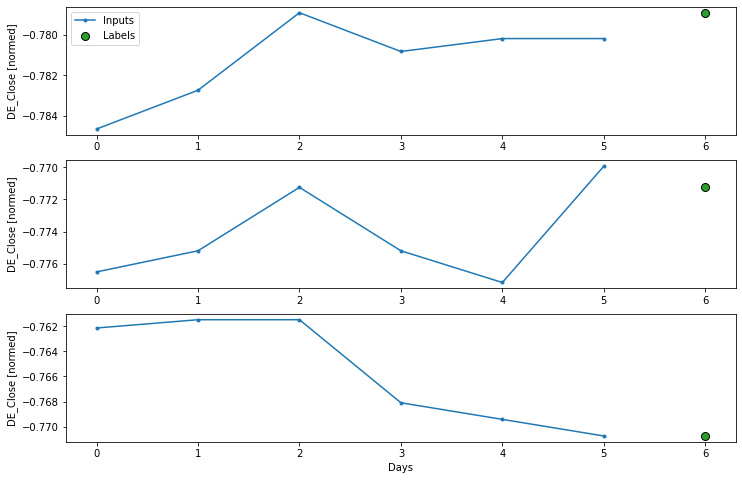

In [ ]:
w2.plot()

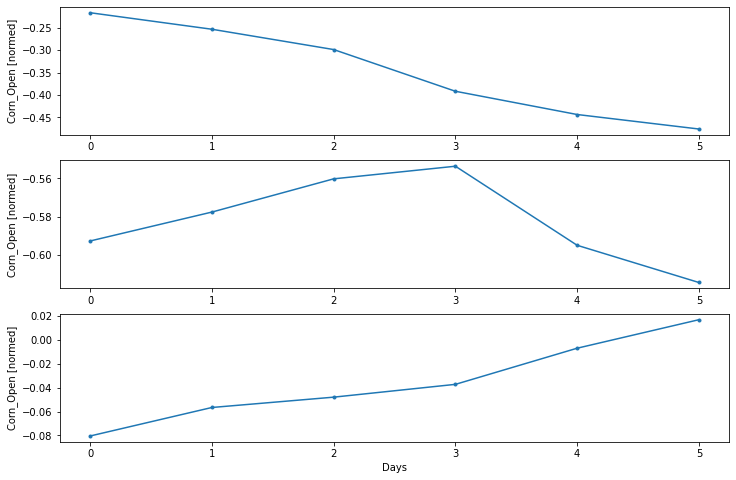

In [ ]:
w2.plot(plot_col='Corn_Open')


In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['DE_Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DE_Close']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['DE_Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

65/65 [==============================] - 0s 3ms/step - loss: 0.0125 - mean_absolute_error: 0.0795


In [ ]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['DE_Close'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['DE_Close']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 5)
Output shape: (32, 30, 1)


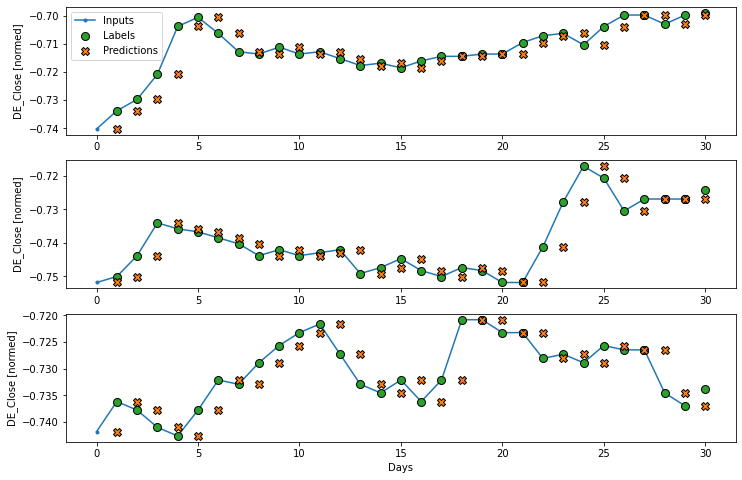

In [ ]:
wide_window.plot(baseline)


In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
226/226 [==============================] - 2s 5ms/step - loss: 1.6355 - mean_absolute_error: 0.8066 - val_loss: 12.5470 - val_mean_absolute_error: 3.1160
Epoch 2/20
226/226 [==============================] - 1s 5ms/step - loss: 0.9077 - mean_absolute_error: 0.6467 - val_loss: 3.6084 - val_mean_absolute_error: 1.5533
Epoch 3/20
226/226 [==============================] - 1s 5ms/step - loss: 0.5845 - mean_absolute_error: 0.5509 - val_loss: 1.3298 - val_mean_absolute_error: 0.9390
Epoch 4/20
226/226 [==============================] - 1s 5ms/step - loss: 0.4119 - mean_absolute_error: 0.4755 - val_loss: 0.8436 - val_mean_absolute_error: 0.7381
Epoch 5/20
226/226 [==============================] - 1s 5ms/step - loss: 0.2963 - mean_absolute_error: 0.4077 - val_loss: 0.6929 - val_mean_absolute_error: 0.6529
Epoch 6/20
226/226 [==============================] - 1s 5ms/step - loss: 0.2101 - mean_absolute_error: 0.3449 - val_loss: 0.5727 - val_mean_absolute_error: 0.5907
Epoch 7/20
226/

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 5)
Output shape: (32, 30, 1)


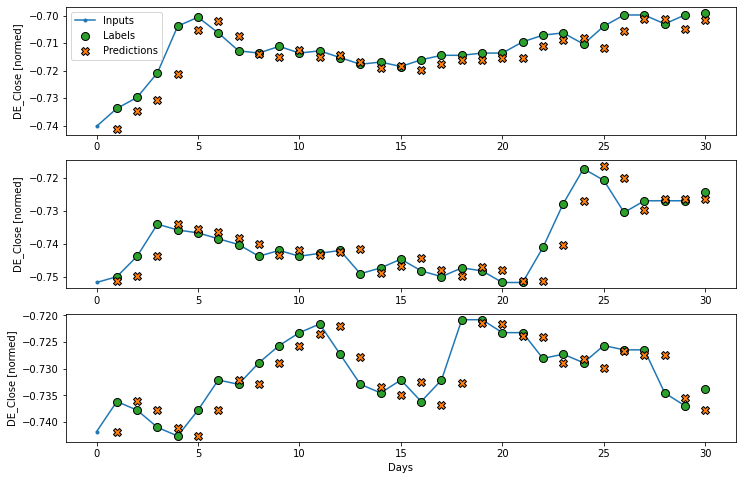

In [ ]:
wide_window.plot(linear)

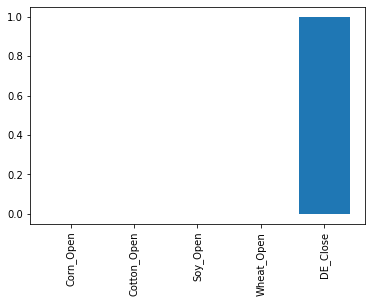

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
226/226 [==============================] - 2s 6ms/step - loss: 0.0616 - mean_absolute_error: 0.1047 - val_loss: 0.3675 - val_mean_absolute_error: 0.4861
Epoch 2/20
226/226 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0266 - val_loss: 0.3280 - val_mean_absolute_error: 0.4636
Epoch 3/20
226/226 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0254 - val_loss: 0.2976 - val_mean_absolute_error: 0.4385
Epoch 4/20
226/226 [==============================] - 1s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0234 - val_loss: 0.2905 - val_mean_absolute_error: 0.4377
Epoch 5/20
226/226 [==============================] - 1s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0229 - val_loss: 0.3001 - val_mean_absolute_error: 0.4537
Epoch 6/20
65/65 [==============================] - 0s 4ms/step - loss: 0.3101 - mean_absolute_error: 0.4623


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['DE_Close'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['DE_Close']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

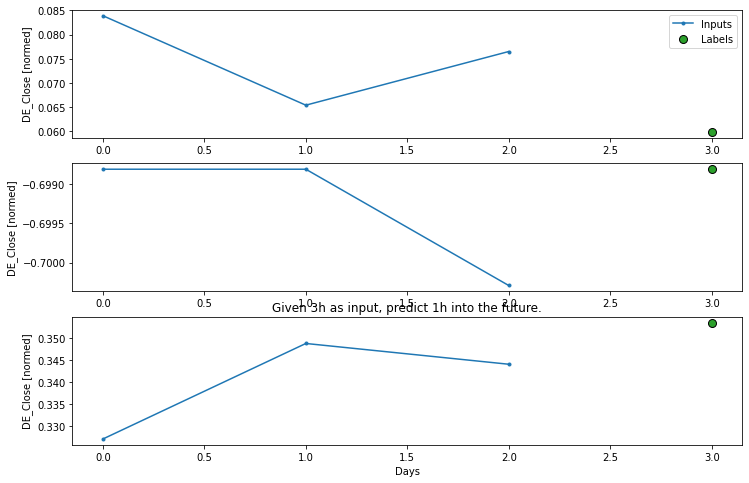

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")